
## Homework 4


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-09-30 23:01:50--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: 'CreditScoring.csv.17'

     0K .......... .......... .......... .......... .......... 28% 3.49M 0s
    50K .......... .......... .......... .......... .......... 56% 7.15M 0s
   100K .......... .......... .......... .......... .......... 84% 2.84M 0s
   150K .......... .......... ........                        100% 11.9M=0.04s

2021-09-30 23:01:51 (4.31 MB/s) - 'CreditScoring.csv.17' saved [182489/182489]




## Preparation




In [3]:
df = pd.read_csv('CreditScoring.csv')

df.columns = df.columns.str.lower()

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)



Prepare the numerical variables:


In [5]:


for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)





Remove clients with unknown default status


In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)



Create the target variable


In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [8]:
df

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,rent,60,39,married,no,fixed,69,92,0,0,900,1020,1
4450,22,owner,60,46,married,no,fixed,60,75,3000,600,950,1263,0
4451,0,owner,24,37,married,no,partime,60,90,3500,0,500,963,1
4452,0,rent,48,23,single,no,freelance,49,140,0,0,550,550,0


In [9]:
len(df.dtypes.index)

14


## Your code

What are the categorical variables? What are the numerical?


In [10]:
categorical = []
numerical = []
for i in range(len(df.dtypes.index)):

    if df.dtypes.values[i] == object:
        categorical.append(df.dtypes.index[i])
    else:
        numerical.append(df.dtypes.index[i])
        


    

In [11]:
print("The categorical varaibles are : %s'\n\n'The numerical variables are : %s " % (categorical,numerical))

The categorical varaibles are : ['home', 'marital', 'records', 'job']'

'The numerical variables are : ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default'] 




Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train,df_test = train_test_split(df,test_size = 0.2,random_state = 1)

In [14]:
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

In [15]:
len(df_train),len(df_val),len(df_test)

(2672, 891, 891)

In [16]:
#resetindex
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#target_variables
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

#delete_target_values_from_dataframe
del df_train['default']
del df_val['default']
del df_test['default']


## Question 1 

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the default variable
    Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.


In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
from sklearn.metrics import roc_curve

In [19]:
auc_seniority = roc_auc_score(y_train,-df_train['seniority'])
auc_seniority

0.7093778624491943

In [20]:
auc_time = roc_auc_score(y_train,df_train['time'])
auc_time

0.5608662489595051

In [21]:
auc_income = roc_auc_score(y_train,-df_train['income'])
auc_income

0.682006666132633

In [22]:
auc_debt = roc_auc_score(y_train,-df_train['debt'])
auc_debt

0.5047829675783548



Which numerical variable (among the following 4) has the highest AUC?

    seniority
    time
    income
    debt



In [23]:
print("The highest AUC is : %s\n\nThe numerical variable with highest AUC is : %s" % (round(max(auc_seniority,auc_time,auc_income,auc_debt),3),"seniority"))

The highest AUC is : 0.709

The numerical variable with highest AUC is : seniority



## Training the model

From now on, use these columns only:

['seniority', 'income', 'assets', 'records', 'job', 'home']

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)



In [24]:
#one-hot-encoding with sklearn
from sklearn.feature_extraction import DictVectorizer

In [25]:
#declaring numerical variables
numerical = ['seniority', 'income', 'assets']

In [26]:
#declaring categorical variables

categorical = ['home', 'records', 'job']

In [27]:
#storing the training set in a dictionary
train_dicts = df_train[categorical + numerical].to_dict(orient='records')


In [28]:
#creating the variable for one hot encoding method function DictVectorizer
dv = DictVectorizer(sparse = False)

In [29]:
#calling the moethod function to ohe the training dictionary
dv.fit(train_dicts)

#training data set is transformed with ohe
X_train = dv.transform(train_dicts)

In [30]:
dv.get_feature_names()

['assets',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'records=no',
 'records=yes',
 'seniority']

In [31]:
X_train

array([[0.0e+00, 0.0e+00, 0.0e+00, ..., 1.0e+00, 0.0e+00, 1.2e+01],
       [0.0e+00, 0.0e+00, 1.0e+00, ..., 1.0e+00, 0.0e+00, 4.0e+00],
       [6.0e+03, 0.0e+00, 0.0e+00, ..., 1.0e+00, 0.0e+00, 0.0e+00],
       ...,
       [0.0e+00, 0.0e+00, 0.0e+00, ..., 0.0e+00, 1.0e+00, 9.0e+00],
       [3.0e+03, 0.0e+00, 0.0e+00, ..., 1.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, ..., 1.0e+00, 0.0e+00, 8.0e+00]])

In [32]:
#storing the valdiation set in a dictionary

val_dicts = df_val[categorical+numerical].to_dict(orient='records')

In [33]:
#validation data set is transformed with ohe
X_val = dv.transform(val_dicts)

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
#model function
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [36]:
#We fit the model with X_train,y_train
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [37]:
#bias_term
model.intercept_

array([0.75439549])

In [38]:
#weights_terms
model.coef_


array([[-2.28850834e-05,  3.57322053e-02,  4.93568561e-01,
        -3.84683890e-01, -1.89330776e-01,  3.00635185e-01,
         4.88863793e-01,  9.61040778e-03, -6.93661563e-03,
        -3.49659768e-01,  1.03760029e-01,  7.70706125e-02,
         9.14944122e-01,  8.28049274e-03, -5.05444320e-01,
         1.25983981e+00, -8.12033050e-02]])

In [39]:
#The target feature is predicted with valdiation set
y_pred = model.predict_proba(X_val)[:,1]

In [40]:
from sklearn.metrics import roc_curve

In [41]:
fpr,tpr,thresholds= roc_curve(y_val,y_pred)

In [42]:
from sklearn.metrics import auc

In [43]:
auc(fpr,tpr)

0.8120879813449298


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.512
    0.612
    0.712
    0.812



In [44]:
print("AUC of this model on the validation dataset : %s" % round(auc(fpr,tpr),3))

AUC of this model on the validation dataset : 0.812



## Question 3

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them



In [45]:
#Creating the thresholds variable
thresholds = np.linspace(0,1,11)

In [46]:
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [47]:

#Actual outcome
actual_positive = (y_val ==1)
actual_negative = (y_val ==0)

#Predicted outcome        
predict_positve = (y_pred>=0.9)
predict_negative = (y_pred<0.9)
        


In [48]:
#TP,FP,TN,FN are calculated

true_positive = (predict_positve & actual_positive).sum()
false_positive =( predict_positve & actual_negative).sum()
        
true_negative = (predict_negative & actual_negative).sum()
false_negative = (predict_negative & actual_positive).sum()
        


In [49]:
#Precision is calculated
precision = true_positive/(true_positive+false_positive)


In [50]:
#Recall is calculated
recall = true_positive/(true_positive+false_negative)

In [51]:
#Functionto calculate precision and recall iterated through different thresholds

def prec_rec(y_val,y_pred):
    thresholds = np.linspace(0,1,11)
    threshold_precision_recall = []
    precision_values = []
    recall_values = []
    
    for t in thresholds:
        actual_positive = (y_val ==1)
        actual_negative = (y_val ==0)
        
        predict_positve = (y_pred>=t)
        predict_negative = (y_pred<t)
        
        true_positive = (predict_positve & actual_positive).sum()
        false_positive =(predict_positve & actual_negative).sum()
        
        true_negative = (predict_negative & actual_negative).sum()
        false_negative = (predict_negative & actual_positive).sum()
        
        if (true_positive + false_positive)==0 or (true_positive+false_negative) ==0 :
            print("Zero Division Error for t = %s" % t)
        else:
            precision = true_positive/(true_positive + false_positive)
            recall = true_positive/(true_positive+false_negative)

            threshold_precision_recall.append((t,precision,recall))
            precision_values.append(precision)
            recall_values.append(recall)
            

        
    return threshold_precision_recall,precision_values,recall_values
    
    


In [52]:
#The thresholds and the corresponding Precision and Recall values are gathered as input from the function prec_rec()
threshold_precision_recall,precision_values,recall_values = prec_rec(y_val,y_pred)

Zero Division Error for t = 1.0


In [53]:
#Precision Values
precision_values

[0.2760942760942761,
 0.34558823529411764,
 0.4460580912863071,
 0.5358166189111748,
 0.5833333333333334,
 0.6404494382022472,
 0.6724137931034483,
 0.6981132075471698,
 0.8076923076923077,
 0.75]

In [54]:
#Recall Values
recall_values

[1.0,
 0.9552845528455285,
 0.8739837398373984,
 0.7601626016260162,
 0.5691056910569106,
 0.4634146341463415,
 0.3170731707317073,
 0.15040650406504066,
 0.08536585365853659,
 0.024390243902439025]

In [55]:
thresholds[:-1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

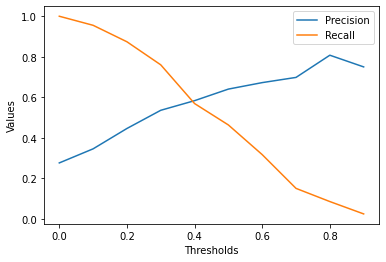

In [56]:
#Plotting the Precision and Recall values across different thresholds
plt.plot(thresholds[:-1],precision_values,label='Precision')
plt.plot(thresholds[:-1],recall_values,label='Recall')

plt.xlabel('Thresholds')
plt.ylabel('Values')

plt.legend()
plt.show()




At which threshold precision and recall curves intersect?

    0.2
    0.4
    0.6
    0.8



In [57]:
print("The threshold at which precision and recall curves intersect is : %s" % 0.4)

The threshold at which precision and recall curves intersect is : 0.4



## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
F1 = 2*((P*R)/(P+R))
Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01


In [58]:
#Function to calculate F1 Scores iterated through different thresholds
def prec_rec_f1(y_val,y_pred):
    thresholds = np.linspace(0,1,11)
    f1_scores = []
    t_f1 = []
    
    for t in thresholds:
        actual_positive = (y_val ==1)
        actual_negative = (y_val ==0)
        
        predict_positve = (y_pred>=t)
        predict_negative = (y_pred<t)
        
        true_positive = (predict_positve & actual_positive).sum()
        false_positive =(predict_positve & actual_negative).sum()
        
        true_negative = (predict_negative & actual_negative).sum()
        false_negative = (predict_negative & actual_positive).sum()
        
        if (true_positive + false_positive)==0 or (true_positive+false_negative) ==0 :
            print("Zero Division Error for t = %s" % t)
        else:
            precision = true_positive/(true_positive + false_positive)
            recall = true_positive/(true_positive+false_negative)
            
            F1 = 2*((precision*recall)/(precision+recall))
            
            f1_scores.append(F1)
            t_f1.append((t,F1))
            

        
    return f1_scores,t_f1
    

In [59]:
#The F1 Scores are gathered as input from the function prec_rec_f1()
f1_scores,t_f1 = prec_rec_f1(y_val,y_pred)

Zero Division Error for t = 1.0


In [60]:
t_f1[1]

(0.1, 0.5075593952483801)

In [61]:
f1_scores

[0.43271767810026385,
 0.5075593952483801,
 0.5906593406593407,
 0.6285714285714286,
 0.5761316872427984,
 0.5377358490566039,
 0.430939226519337,
 0.24749163879598665,
 0.15441176470588236,
 0.04724409448818898]



At which threshold F1 is maximal?

    0.1
    0.3
    0.5
    0.7



In [62]:
x = []
for i in t_f1:
    x.append(i[1])
    
    if len(x) == len(t_f1):
        max_f1 = max(x)
        
        for j in t_f1:
            if (j)[1] ==  max_f1:
                print("The max F1 score is %s and the corresponding threshold is %s" %(max_f1,round(((j)[0]),2)))
                
        
   
        

    
    

The max F1 score is 0.6285714285714286 and the corresponding threshold is 0.3



## Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation



In [63]:
#KFold class is imported from sci-kit learn
from sklearn.model_selection import KFold

In [64]:
#tqdm is imported
from tqdm.auto import tqdm

In [65]:
#Function to train the model
def train(df_train,y_train,C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C,max_iter=1000)
    model.fit(X_train,y_train)

    return dv,model

In [66]:
#Function to predict the model
def predict(df_val,dv,model):
    dicts = df_val[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [67]:
#Function to train the model and evaluate AUC in the validation set using KFold - n_splits set to 5
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

Auc_Scores = []
n_split = 0

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    Auc_Score = roc_auc_score(y_val, y_pred)
    Auc_Scores.append(Auc_Score)
    n_split = n_split + 1
    
    
    print('n_split=%s %.3f +- %.3f' % (n_split, np.mean(Auc_Scores), np.std(Auc_Scores)))
        


n_split=1 0.826 +- 0.000
n_split=2 0.826 +- 0.000
n_split=3 0.813 +- 0.017
n_split=4 0.814 +- 0.015
n_split=5 0.812 +- 0.014




How large is standard devidation of the scores across different folds?

    0.001
    0.014
    0.09
    0.14



In [68]:
print("Standard devidation of the scores across different folds : %s" % round(np.std(Auc_Scores),3))

Standard devidation of the scores across different folds : 0.014



## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.01, 0.1, 1, 10]
    Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std



In [69]:
#Function to train the model and evaluate AUC in the validation set using KFold - n_splits set to 5 iterated through different C parameters
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    Auc_Scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        Auc_Score = roc_auc_score(y_val, y_pred)
        Auc_Scores.append(Auc_Score)

    print('C=%s %.3f +- %.3f' % (C, np.mean(Auc_Scores), np.std(Auc_Scores)))

 25%|██▌       | 1/4 [00:00<00:01,  2.33it/s]

C=0.01 0.809 +- 0.013


 50%|█████     | 2/4 [00:00<00:00,  2.43it/s]

C=0.1 0.812 +- 0.013


 75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

C=1 0.812 +- 0.014


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

C=10 0.814 +- 0.015




Which C leads to the best mean score?

    0.01
    0.1
    1
    10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C
